# Определение наиболее выгодного региона нефтедобычи

Заказчик - нефтяная компания поставила задачу решить, где бурить новую скважину.
Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль, а также проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Введение и подготовка необходимых библиотек

Перед началом работы и подготовкой данных выгрузим все необходимые библиотеки. Затем перейдем к исследованию данных и их обработке для дальнейшего обучения модели и решения задачи.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from scipy import stats as st
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    precision_score,
    recall_score,
    r2_score, 
    mean_squared_error,
    mean_absolute_error

)
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder, StandardScaler




Необходимые библиотеки выгружены. Перейдем к выгрузке и анализу данных.

### Выгрузка данных

Как было сказано выше - у нас 3 датасета с данными о 3-х регионах добычи нефти. Назовем их df1, df2, df3.

In [2]:
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:

for i in range(1, 4):
    globals()['df{i}'] = pd.read_csv(f'/datasets/geo_data_{i-1}.csv')

### Исследование и подготовка данных

Выведем информацию о датасетах методом info(), а также посмотрим нет ли в данных пропусков.

In [7]:
print('Dataset 1')
df1.info()
df1.isna().count()

Dataset 1

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 100000 entries, 0 to 99999

Data columns (total 5 columns):

 #   Column   Non-Null Count   Dtype  

---  ------   --------------   -----  

 0   id       100000 non-null  object 

 1   f0       100000 non-null  float64

 2   f1       100000 non-null  float64

 3   f2       100000 non-null  float64

 4   product  100000 non-null  float64

dtypes: float64(4), object(1)

memory usage: 3.8+ MB


id         100000
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [8]:
print('Dataset 2')
df2.info()
df2.isna().count()

Dataset 2

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 100000 entries, 0 to 99999

Data columns (total 5 columns):

 #   Column   Non-Null Count   Dtype  

---  ------   --------------   -----  

 0   id       100000 non-null  object 

 1   f0       100000 non-null  float64

 2   f1       100000 non-null  float64

 3   f2       100000 non-null  float64

 4   product  100000 non-null  float64

dtypes: float64(4), object(1)

memory usage: 3.8+ MB


id         100000
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [9]:
print('Dataset 3')
df3.info()
df3.isna().count()

Dataset 3

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 100000 entries, 0 to 99999

Data columns (total 5 columns):

 #   Column   Non-Null Count   Dtype  

---  ------   --------------   -----  

 0   id       100000 non-null  object 

 1   f0       100000 non-null  float64

 2   f1       100000 non-null  float64

 3   f2       100000 non-null  float64

 4   product  100000 non-null  float64

dtypes: float64(4), object(1)

memory usage: 3.8+ MB


id         100000
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Наш датасет состоит из 5 колонок - идентификатор скважины, три признака точек и объем запасов сырья. Для дальнейшего обучения модели столбец с идентификатором 'id' не несет никакой смысловой нагрузки. Удалим его в каждом датасете.

In [10]:
df1 = df1.drop('id', axis = 1, inplace=False)
df2 = df2.drop('id', axis = 1, inplace=False)
df3 = df3.drop('id', axis = 1, inplace=False)



In [11]:
print(df1.head(2))
print(df2.head(2))
print(df3.head(2))

         f0        f1       f2     product

0  0.705745 -0.497823  1.22117  105.280062

1  1.334711 -0.340164  4.36508   73.037750

          f0        f1        f2    product

0 -15.001348 -8.276000 -0.005876   3.179103

1  14.272088 -3.475083  0.999183  26.953261

         f0        f1        f2    product

0 -1.146987  0.963328 -0.828965  27.758673

1  0.262778  0.269839 -2.530187  56.069697


Столбец id удалился. Переходим дальше.

Для интересующей нас модеди линейной регрессии важно, чтобы не было мультиколлинеарности, то есть ситуации, когда две независимые переменные имеют сильную корреляцию.

Чтобы проверить взаимосвязь между нашими переменными выведем коэффициенты корреляции на экран и построим heatmap корреляции с использованием seaborn по каждому датасету.

Датасет 1

               f0        f1        f2   product

f0       1.000000 -0.440723 -0.003153  0.143536

f1      -0.440723  1.000000  0.001724 -0.192356

f2      -0.003153  0.001724  1.000000  0.483663

product  0.143536 -0.192356  0.483663  1.000000


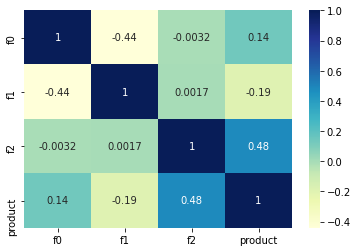

In [12]:
print(df1.corr())  
    
df1_plot = sns.heatmap(df1.corr(), cmap="YlGnBu", annot=True)  
    
plt.show()

В первом датасете коэффициенты корреляции разбросаны сильно - это показывает наличие не явно выраженной зависимости признаков друг от друга. Единственное, на что обращаем внимание - зависимость признака 'product' от 'f2', но и она выражена не так сильно.

Датасет 2

               f0        f1        f2   product

f0       1.000000  0.182287 -0.001777 -0.030491

f1       0.182287  1.000000 -0.002595 -0.010155

f2      -0.001777 -0.002595  1.000000  0.999397

product -0.030491 -0.010155  0.999397  1.000000


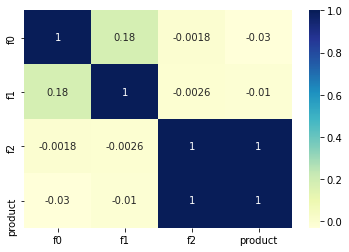

In [13]:
print(df2.corr())  
    
df2_plot = sns.heatmap(df2.corr(), cmap="YlGnBu", annot=True)  
    
plt.show()

Здесь заметна сильная зависимость показателя 'profit' от признака 'f0'. Эта зависимость может показать высокие значения предсказаний в дальнейшем применении модели. 

Датасет 3

               f0        f1        f2   product

f0       1.000000  0.000528 -0.000448 -0.001987

f1       0.000528  1.000000  0.000779 -0.001012

f2      -0.000448  0.000779  1.000000  0.445871

product -0.001987 -0.001012  0.445871  1.000000


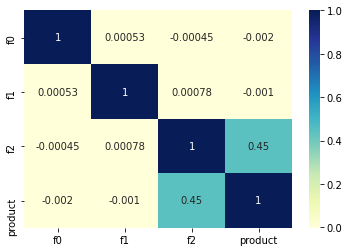

In [14]:
print(df3.corr())  
    
df3_plot = sns.heatmap(df3.corr(), cmap="YlGnBu", annot=True)  
    
plt.show()

В третьем датасете также прослеживается зависимость признака 'product' от признака 'f2', правда коэффициент корреляции здесь немного меньше.

Проверим наши данные на дубликаты. Для этого воспользуемся методом duplicated().sum() для каждого датасета.

In [15]:
print('Количество дубликатов в Датасете 1:', df1.duplicated().sum())
print('Количество дубликатов в Датасете 2:', df2.duplicated().sum())
print('Количество дубликатов в Датасете 3:', df3.duplicated().sum())

Количество дубликатов в Датасете 1: 0

Количество дубликатов в Датасете 2: 0

Количество дубликатов в Датасете 3: 0


Как видим из полученных данных - дубликаты в наших датасетах отсутствуют.

Мы произвели подготовку данных, посмотрели их структуру, проверили на наличие пропусков, удалили неинтересующую нас колонку 'id' (идентификатор скважины), рассмотрели коэффициенты корреляции между признаками (сильная зависимость (коэффициент 1) прослеживается только во втором датасете) чтобы избежать мультиколлинеарности., а также проверили данные на наличие дубликатов.

Теперь можно сказать, что данные подготовлены к обучению. Остальные шаги, такие как разбивка на выборки, масштабирование и др. будем делать по ходу обучения.

## Обучение и проверка модели

### Работа с признаками и разбитие данных на выборки

Для разбивки на выборки необходимо выбрать признаки для нашей модели. Целевым признаком во всех 3-х датасетах будет выступать product (объем запасов в скважине). Тестовыми признаками будут все остальные. Запишем это в коде для каждого датасета.

In [16]:
target1 = df1['product']
features1 = df1.drop(['product'], axis=1)

target2 = df2['product']
features2 = df2.drop(['product'], axis=1)

target3 = df3['product']
features3 = df3.drop(['product'], axis=1)


Целевые и тестовые признаки объявлены в переменных. Разобьем данные на выборки и проведем стандартизацию.

В нашей зедаче предлагаю разбить данные методом train_test_split() следующим образом:
- 75% данных на тренировочкую выборку
- 25% данных на валидационную выборку

Для этого размер test_size поставим равным 0,25. Повторим эту процедуру для каждого датасета.

In [17]:
RANDOM_STATE = 12345

features_train1, features_valid1, target_train1, target_valid1 = train_test_split(
    features1, 
    target1, 
    test_size=0.25, 
    random_state=RANDOM_STATE
)

features_train2, features_valid2, target_train2, target_valid2 = train_test_split(
    features2,
    target2, 
    test_size=0.25,
    random_state=RANDOM_STATE
)

features_train3, features_valid3, target_train3, target_valid3 = train_test_split(
    features3,
    target3, 
    test_size=0.25,
    random_state=RANDOM_STATE
)

Проверим размер каждой из выборок методом shape.

In [18]:
print('Размер тренировочной выборки тестовых признаков Датасета 1:', features_train1.shape)
print('Размер тренировочной выборки целевого признака Датасета 1:', target_train1.shape)
print('Размер валидационной выборки тестовых признаков Датасета 1:', features_valid1.shape)
print('Размер валидационной выборки целевого признака Датасета 1:', target_valid1.shape)

print('Размер тренировочной выборки тестовых признаков Датасета 2:', features_train2.shape)
print('Размер тренировочной выборки целевого признака Датасета 2:', target_train2.shape)
print('Размер валидационной выборки тестовых признаков Датасета 2:', features_valid2.shape)
print('Размер валидационной выборки целевого признака Датасета 2:', target_valid2.shape)

print('Размер тренировочной выборки тестовых признаков Датасета 3:', features_train3.shape)
print('Размер тренировочной выборки целевого признака Датасета 3:', target_train3.shape)
print('Размер валидационной выборки тестовых признаков Датасета 3:', features_valid3.shape)
print('Размер валидационной выборки целевого признака Датасета 3:', target_valid3.shape)

Размер тренировочной выборки тестовых признаков Датасета 1: (75000, 3)

Размер тренировочной выборки целевого признака Датасета 1: (75000,)

Размер валидационной выборки тестовых признаков Датасета 1: (25000, 3)

Размер валидационной выборки целевого признака Датасета 1: (25000,)

Размер тренировочной выборки тестовых признаков Датасета 2: (75000, 3)

Размер тренировочной выборки целевого признака Датасета 2: (75000,)

Размер валидационной выборки тестовых признаков Датасета 2: (25000, 3)

Размер валидационной выборки целевого признака Датасета 2: (25000,)

Размер тренировочной выборки тестовых признаков Датасета 3: (75000, 3)

Размер тренировочной выборки целевого признака Датасета 3: (75000,)

Размер валидационной выборки тестовых признаков Датасета 3: (25000, 3)

Размер валидационной выборки целевого признака Датасета 3: (25000,)


Все данные разбиты в пропорции 3/1. Разбивка на выборки прошла успешна. Теперь стандартизируем признаки с помощью StandardScaler. Это поможет избавиться от придания алгоритмом большей важности признакам, которые численно больше, что в свою очередь улучшит качество модели линейной регрессии. Для начала создадим список из названий столбцов, данные в которых необходимо масштабировать. Затем воспользуемся методом scaler и сохраним масштабированные выборки в те же переменные. И так для каждого датасета.

In [19]:
numeric = ['f0', 'f1', 'f2']#создадим список

scaler_1 = StandardScaler()#применим StandardScaler к 1 региону
scaler_1.fit(features_train1[numeric])
features_train1[numeric] = scaler_1.transform(features_train1[numeric])
features_valid1[numeric] = scaler_1.transform(features_valid1[numeric])

scaler_2 = StandardScaler()#применим StandardScaler ко 2 региону
scaler_2.fit(features_train2[numeric])
features_train2[numeric] = scaler_2.transform(features_train2[numeric])
features_valid2[numeric] = scaler_2.transform(features_valid2[numeric])

scaler_3 = StandardScaler()#применим StandardScaler к 3 региону
scaler_3.fit(features_train3[numeric])
features_train3[numeric] = scaler_3.transform(features_train3[numeric])
features_valid3[numeric] = scaler_3.transform(features_valid3[numeric])

pd.options.mode.chained_assignment = None

print(features_train1.head(2))
print(features_train2.head(2))
print(features_train3.head(2))

             f0        f1        f2

27212 -0.544828  1.390264 -0.094959

7866   1.455912 -0.480422  1.209567

             f0        f1        f2

27212 -0.850855  0.624428  0.296943

7866   1.971935  1.832275  0.294333

             f0        f1        f2

27212 -0.526160  0.776329 -0.400793

7866  -0.889625 -0.404070 -1.222936


/tmp/ipykernel_31/2217662880.py:5: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  features_train1[numeric] = scaler_1.transform(features_train1[numeric])

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self._setitem_single_block(indexer, value, name)

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [20]:
# КОД РЕВЬЮЕРА
scaler = StandardScaler()
features_train_list = [features_train1, features_train2, features_train3]
features_valid_list = [features_valid1, features_valid2, features_valid3]

for i in range(3):
    scaler.fit_transform(features_train_list[i])
    features_valid_list[i] = scaler.transform(features_valid_list[i])

Тестовые признаки для каждого датасета стандартизированны. Мы готовы к обучению модели.

### Обучение модели

Итак, для обучения мы будем использовать модель линейной регрессии. Обучим ее и сделаем предсказания на валидационной выборке. Проверим полученные результаты метрикой RMSE (квадратный корень из средней квадратичной ошибки) и R2 (коэффициент детерминации) по каждому датасету. 

Датасет 1

In [21]:
model1=LinearRegression()
model1.fit(features_train1,target_train1)
predict1=model1.predict(features_valid1)
rmse1 = mean_squared_error(target_valid1, predict1)**0.5
print('RMSE:', rmse1)
print('Коэффициент детерминации:', r2_score(target_valid1, predict1))

RMSE: 37.5794217150813

Коэффициент детерминации: 0.27994321524487786


R2 больше 0 и стремится к единице (0,279), RMSE 37,5 - модель работает хорошо.

Датасет 2

In [22]:
model2=LinearRegression()
model2.fit(features_train2,target_train2)
predict2=model2.predict(features_valid2)
rmse2 = mean_squared_error(target_valid2, predict2)**0.5
print('RMSE:', rmse2)
print('Коэффициент детерминации:', r2_score(target_valid2, predict2))

RMSE: 0.893099286775617

Коэффициент детерминации: 0.9996233978805127


Во втором датасете показатели изменились. Коэффициент детерминации 0,99, а RMSE 0,91.

In [23]:
model3=LinearRegression()
model3.fit(features_train3,target_train3)
predict3=model3.predict(features_valid3)
rmse3 = mean_squared_error(target_valid3, predict3)**0.5
print('RMSE:', rmse3)
print('Коэффициент детерминации:', r2_score(target_valid3, predict3))

RMSE: 40.02970873393434

Коэффициент детерминации: 0.20524758386040443


Здесь можно отметить самый низкий коэффициент детерминации - 0,2.

### Сохранение предсказаний и правильных ответов

Предсказания и правильные ответы моделей сохраним в переменных predict и target_valid для каждого датасета соответственно.

Датасет 1:
- Предсказания в переменной "predict1"
- Правильные ответы в переменной "target_valid1"

Датасет 2:
- Предсказания в переменной "predict2"
- Правильные ответы в переменной "target_valid2"

Датасет 3:
- Предсказания в переменной "predict3"
- Правильные ответы в переменной "target_valid3"

### Средний запас предсказанного сырья и RMSE модели

Выведем на экран таблицу, в которой будут интересующие нас параметры для каждого из датасетов. Для этого создадим новый датафрейм, в котором передадим колонкам названия наших 3-х датасетов, а строкам - интересующие нас метрики (RMSE и средний запас предсказанного сырья).

In [24]:
table = pd.DataFrame(index=['RMSE модели','Средний запас предсказанного сырья (тыс. баррелей)'], columns=['Датасет 1','Датасет 2','Датасет 3'])
table['Датасет 1'] = rmse1, predict1.mean()
table['Датасет 2'] = rmse2, predict2.mean()
table['Датасет 3'] = rmse3, predict3.mean()
table




,Датасет 1,Датасет 2,Датасет 3
RMSE модели,37.579422,0.893099,40.029709
Средний запас предсказанного сырья (тыс. баррелей),92.592568,68.728547,94.965046


Как мы видим из полученных данных - метрики RMSE в принципе несильно отличаются друг от друга. А вот по 2 датасету (региону добычи) модель предсказала наименьшие добычи. Учтем этот момент в дальнейшем исследовании.

Таким образом, мы разбили данные на тренировочную и валидационную выборки (в соотножении 75/25), стандартизировали признаки. Затем мы обучили модель линейной регрессии по 3-м датасетам (которые являются информацией по регионам добычи нефти) и получили объемы предсказанного сырья. В нашем случае лидирующим по предсказанному объему является третий датасет, затем идет первый, а замыкает тройку с сильным отставание датасет по 2 региону добычи. Мы учтем эти выводы при дальнейшем решении поставленной бизнес-задачи.

## Подготовка к расчёту прибыли

### Подготовка необходимых переменных

Обозначим новые переменные, в которых сохраним все ключевые данные для расчетов:
- bgt (бюджет на разработку скважин в регионе — 10 000 000 тыс. рублей (10 млрд));
- inc (доход с каждой единицы продукта - 450 тыс. рублей, поскольку объём указан в тысячах баррелей);
- loss_prob (вероятность убытков - по условию должна быть меньше 2,5%);
- bgt_oilwell (бюджет на разработку одной из 200 скважин).



In [25]:
bgt = 10000000
bgt_oilwell = bgt/200
inc = 450
loss_prob = 2.5/100
product_mean1 = df1['product'].mean()
product_mean2 = df2['product'].mean()
product_mean3 = df3['product'].mean()

Выведем интересующие нас данные на экран.

In [26]:
print(f'Общий бюджет на разработку составляет: {bgt} тыс. руб.')
print()
print(f'Бюджет на разработку одной скважины составляет: {bgt_oilwell} тыс. руб.')
print()
print(f'Cредний запас сырья по 1 региону составляет: {product_mean1} млн. баррелей')
print(f'Cредний запас сырья по 2 региону составляет: {product_mean2} млн. баррелей')
print(f'Cредний запас сырья по 3 региону составляет: {product_mean3} млн. баррелей')


Общий бюджет на разработку составляет: 10000000 тыс. руб.



Бюджет на разработку одной скважины составляет: 50000.0 тыс. руб.



Cредний запас сырья по 1 региону составляет: 92.50000000000001 млн. баррелей

Cредний запас сырья по 2 региону составляет: 68.82500000000002 млн. баррелей

Cредний запас сырья по 3 региону составляет: 95.00000000000004 млн. баррелей


### Рассчет достаточного объёма сырья

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины, а затем сравним полученный объём сырья со средним запасом в каждом регионе (в каждом датасете). Также рассчитаем коэффициент возврата инвестиций (ROI) для каждого региона - ведь, по сути, освоение новой скважины это инвестиция для дальнейшего получения прибыли.

In [27]:
suf_v = bgt_oilwell/inc
print('Объем сырья из каждой скважины для безубыточной разработки должен составлять не менее %.2f'%suf_v, 'тыс.баррелей')

Объем сырья из каждой скважины для безубыточной разработки должен составлять не менее 111.11 тыс.баррелей


Теперь необходимо сравнить полученный объем со средним объемом запасов по каждому региону. Для этого нам потребуется посчитать:
- Прибыль по каждой скважине в регионе (будем считать как объем сырья, умноженный на доход с каждой тысячи баррелей),
- Коэффициент ROI (будем считать, как (прибыль по каждой скважине - бюджет на разработку одной)/бюджет на разработку одной * 100%),
- Разницу между объемом для безубыточной добычи и средним запасом по региону.

Начнем с датасета 1 (1 регион).

In [28]:
df1['profit'] = df1['product']*inc #добавили новый столбец с прибылью (profit)
df1.head()

,f0,f1,f2,product,profit
0,0.705745,-0.497823,1.221170,105.280062,47376.027830
1,1.334711,-0.340164,4.365080,73.037750,32866.987619
2,1.022732,0.151990,1.419926,85.265647,38369.541209
3,-0.032172,0.139033,2.978566,168.620776,75879.349000
4,1.988431,0.155413,4.751769,154.036647,69316.491032


In [29]:
df1['ROI (%)'] = (df1['profit'] - bgt_oilwell)/bgt_oilwell*100 #добавили столбец с коэффициентом ROI
df1.head()

,f0,f1,f2,product,profit,ROI (%)
0,0.705745,-0.497823,1.221170,105.280062,47376.027830,-5.247944
1,1.334711,-0.340164,4.365080,73.037750,32866.987619,-34.266025
2,1.022732,0.151990,1.419926,85.265647,38369.541209,-23.260918
3,-0.032172,0.139033,2.978566,168.620776,75879.349000,51.758698
4,1.988431,0.155413,4.751769,154.036647,69316.491032,38.632982


In [30]:
print(f'Разница между объемом безубыточной добычи и средним запасом сырья по региону 1 составляет {(suf_v - product_mean1).round(2)} тыс. баррелей')                                                                                             
                                                                                                    

Разница между объемом безубыточной добычи и средним запасом сырья по региону 1 составляет 18.61 тыс. баррелей


2 Датасет (регион).

In [31]:
df2['profit'] = df2['product']*inc #добавили новый столбец с прибылью (profit)
df2.head()

,f0,f1,f2,product,profit
0,-15.001348,-8.276000,-0.005876,3.179103,1430.596162
1,14.272088,-3.475083,0.999183,26.953261,12128.967464
2,6.263187,-5.948386,5.001160,134.766305,60644.837321
3,-13.081196,-11.506057,4.999415,137.945408,62075.433483
4,12.702195,-8.147433,5.004363,134.766305,60644.837321


In [32]:
df2['ROI (%)'] = (df2['profit'] - bgt_oilwell)/bgt_oilwell*100 #добавили столбец с коэффициентом ROI
df2.head()

,f0,f1,f2,product,profit,ROI (%)
0,-15.001348,-8.276000,-0.005876,3.179103,1430.596162,-97.138808
1,14.272088,-3.475083,0.999183,26.953261,12128.967464,-75.742065
2,6.263187,-5.948386,5.001160,134.766305,60644.837321,21.289675
3,-13.081196,-11.506057,4.999415,137.945408,62075.433483,24.150867
4,12.702195,-8.147433,5.004363,134.766305,60644.837321,21.289675


In [33]:
print(f'Разница между объемом безубыточной добычи и средним запасом сырья по региону 2 составляет {(suf_v - product_mean2).round(2)} тыс. баррелей')                                                                                             


Разница между объемом безубыточной добычи и средним запасом сырья по региону 2 составляет 42.29 тыс. баррелей


3 Датасет (регион).

In [34]:
df3['profit'] = df3['product']*inc #добавили новый столбец с прибылью (profit)
df3.head()

,f0,f1,f2,product,profit
0,-1.146987,0.963328,-0.828965,27.758673,12491.402954
1,0.262778,0.269839,-2.530187,56.069697,25231.363485
2,0.194587,0.289035,-5.586433,62.871910,28292.359521
3,2.236060,-0.553760,0.930038,114.572842,51557.778750
4,-0.515993,1.716266,5.899011,149.600746,67320.335661


In [35]:
df3['ROI (%)'] = (df3['profit'] - bgt_oilwell)/bgt_oilwell*100 #добавили столбец с коэффициентом ROI
df3.head()

,f0,f1,f2,product,profit,ROI (%)
0,-1.146987,0.963328,-0.828965,27.758673,12491.402954,-75.017194
1,0.262778,0.269839,-2.530187,56.069697,25231.363485,-49.537273
2,0.194587,0.289035,-5.586433,62.871910,28292.359521,-43.415281
3,2.236060,-0.553760,0.930038,114.572842,51557.778750,3.115558
4,-0.515993,1.716266,5.899011,149.600746,67320.335661,34.640671


In [36]:
print(f'Разница между объемом безубыточной добычи и средним запасом сырья по региону 3 составляет {(suf_v - product_mean3).round(2)} тыс. баррелей')

Разница между объемом безубыточной добычи и средним запасом сырья по региону 3 составляет 16.11 тыс. баррелей


Получившиеся положительные числа разниц говорят нам о том, что во всех 3-х регионах средних запасов сырья не хватает для окупаемости разработок новых скважин. Поэтому, средняя оценка здесь не подходит. Попробуем, на основании предсказаний модели, найти скважины с максимальным количеством запасов сырья.

## Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

Для написания функции и дальнейшего исследования нам необходимо выбрать скважины, значения предсказаний нашей модели по которым максимально. Для этого возьмем из переменных predict(1,2,3) предсказания количества объемов сырья, создадим новую переменную probs_sorted (датафрейм, в котором будут значения предсказаний, отсортированные по убыванию), переменную probs_max (скважины, где объем сырья максимальный с промежутком от начала и до 200 элемента).

Перенесем все эти данные в функцию, чтобы можно было подставить значение по любому региону. Функцию назовем calc_profit (калькулятор доходности). 

In [37]:
def calc_profit(predict,target):
    probs_sorted = pd.Series(predict, index=target.index).sort_values(ascending=False)
    probs_max = probs_sorted[:200].sum()
    print('Сумма запаса сырья в 200 лучших скважинах составит: %.2f тыс. баррелей'%probs_max)

Проверим работу функции на 1 датасете.

In [38]:
calc_profit(predict1, target_valid1)

Сумма запаса сырья в 200 лучших скважинах составит: 31102.33 тыс. баррелей


Теперь 2 датасет.

In [39]:
calc_profit(predict2, target_valid2)

Сумма запаса сырья в 200 лучших скважинах составит: 27746.03 тыс. баррелей


3 Датасет.

In [40]:
calc_profit(predict3, target_valid3)

Сумма запаса сырья в 200 лучших скважинах составит: 29603.90 тыс. баррелей


Как мы видим из работы функции - все регионы добычи потенциально прибыльны. Приступим к расчету прибыли и рисков.

## Расчёт прибыли и рисков 

### Распределение прибыли, доверительный интервал и риски убытков

Для поиска распределения прибыли будем использовать технику BootStrap, которой укажем создать 1000 подвыборок. 

Предлагаю использовать функцию, которая на вход примет предсказания и правильные ответы по региону, а на выходе даст распределение прибыли, 95%-й доверительный интервал и оценит риски.

Для начала создадим вспомогательную функцию calc_profit_2 для метода BootStrap по аналогии с предыдущим шагом. Итак, приступим.

In [95]:
def calc_profit_2(predict,target):  #создадим функцию по расчету дохода на скважину
    predict = pd.Series(predict).reset_index(drop=True)
    target = target.reset_index(drop=True)
    wells_sorted = predict.sort_values(ascending=False) 
    selected = target[wells_sorted.index][:200]


    
    if target[wells_sorted.index].shape[0] != wells_sorted.index.shape[0]:
        print("Shape mismatch! Actual selected targets shape:", target[wells_sorted.index].shape)


    product = selected.sum()
    revenue = (product * inc) - bgt
    return revenue

In [97]:

for i in range(1, 4):
    print("Регион", i)
    profit = calc_profit_2(
        globals()[f'predict{i}'],
        globals()[f'target_valid{i}']
    )
    print(f"Прибыль по 200 лучшим скважинам = {profit:.2f}")

Регион 1

Прибыль по 200 лучшим скважинам = 3320826.04

Регион 2

Прибыль по 200 лучшим скважинам = 2415086.70

Регион 3

Прибыль по 200 лучшим скважинам = 2710349.96


In [98]:
def revenue_bootstrap(target,predict):
    values = []
    count=0 #создадим счетчик для убытка
    state = np.random.RandomState(12345)
    predict_e = pd.Series(predict, index=target.index)
    
    for i in range(1000):
        target_subsample = target.sample(n=500,replace=True, random_state=state)#500 скважин исследуем
        wells_subsample = predict_e[target_subsample.index]
        values.append(calc_profit_2(wells_subsample,target_subsample))
    for i in values:
        if i < 0:
            count +=1 #добавляем элемент, если прибыль меньше 0 (убыток)
            
    values = pd.Series(values) 
    revenue_mean = values.mean() #средняя выручка
    
    lower = values.quantile(0.025) #так как нам нужен 95%-й интервал отступаем по 2.5 с каждой стороны
    higher = values.quantile(0.975) #итого получаем 0,025 и 0,975
    
    print('Для выбранного региона:')
    print('Средняя прибыль составляет {:.2f} млн.руб'.format(revenue_mean/1000))
    print('С вероятностью в 95% прибыль будет составлять от: {:.2f} млн.руб до: {:.2f} млн.руб'.format((lower/1000),(higher/1000)))
    print ('Процент вероятности убытка составит {:.1%}'.format(count/1000))
    

Функция создана - провеерим ее работу на наших регионах.

Регион 1 (Датасет 1)

In [100]:
revenue_bootstrap(target_valid1,predict1)

Для выбранного региона:

Средняя прибыль составляет 396.16 млн.руб

С вероятностью в 95% прибыль будет составлять от: -111.22 млн.руб до: 909.77 млн.руб

Процент вероятности убытка составит 6.9%


Регион 2 (Датасет 2)

In [101]:
revenue_bootstrap(target_valid2,predict2)

Для выбранного региона:

Средняя прибыль составляет 456.05 млн.руб

С вероятностью в 95% прибыль будет составлять от: 33.82 млн.руб до: 852.29 млн.руб

Процент вероятности убытка составит 1.5%


Регион 3 (Датасет 3)

In [102]:
revenue_bootstrap(target_valid3,predict3)

Для выбранного региона:

Средняя прибыль составляет 404.40 млн.руб

С вероятностью в 95% прибыль будет составлять от: -163.35 млн.руб до: 950.36 млн.руб

Процент вероятности убытка составит 7.6%


### Сравнение регионов по полученным показателям

Для наглядности поместим наши данные в таблицу. Для удобства создадим функцию tabless, которая заполнит нашу таблицу данными.

In [103]:
def tabless(target,predict):
    values = []
    count=0
    state = np.random.RandomState(12345)
    predict_e = pd.Series(predict, index=target.index)
    
    for i in range(1000):
        target_subsample = target.sample(n=500,replace=True, random_state=state) #500 скважин исследуем
  
        wells_subsample = predict_e[target_subsample.index]
        values.append(calc_profit_2(wells_subsample,target_subsample))  
    for i in values:
        if i < 0:
            count +=1
    
    wells_sorted = pd.Series(predict, index=target.index).sort_values(ascending=False)
    wells_max = wells_sorted[:200].sum() #расчет суммарного запаса сырья из предыдущей функции
    values = pd.Series(values)
    revenue_mean = values.mean() #средняя выручка
    
    lower = values.quantile(0.025) #так как нам нужен 95%-й интервал отступаем по 2.5 с каждой стороны
    higher = values.quantile(0.975) #итого получаем 0,025 и 0,975
    
    return revenue_mean/1000, wells_max , count/10


In [104]:
comparing = pd.DataFrame(index=['Средняя прибыль региона (млн.руб)','Суммарный запас сырья (тыс. баррелей)','Вероятность убытка (%)'], 
                        columns=['Регион 1','Регион 2','Регион 3']
                        )
comparing['Регион 1'] = tabless(target_valid1, predict1)
comparing['Регион 2'] = tabless(target_valid2, predict2)
comparing['Регион 3'] = tabless(target_valid3, predict3)

comparing

,Регион 1,Регион 2,Регион 3
Средняя прибыль региона (млн.руб),396.164985,456.045106,404.403867
Суммарный запас сырья (тыс. баррелей),31102.330839,27746.026782,29603.898658
Вероятность убытка (%),6.900000,1.500000,7.600000


После оценки рисков нам необходимо оставить только те регионы, в которых вероятность убытков меньше 2.5%.


Как мы видим из полученной таблицы - такой регион всего один (Регион 2). В нем вероятность убытков составляет 1,5%. В 1 регионе 6,9%, во 2-м - 7,6%. Также 2-й регион отличается высоким показателем прогнозируемой средней прибыли со скважины - 456,04 млн. рублей.

## Общий вывод

Нами была проделана большая работа по поиску региона, где разработка новой скважины компанией-заказчиком принесет наибольшую прибыль.

Для анализа были предоставлены данные по 3-м регионам разработки. После исследования всех трех датасетов было обнаружено, что каждый из датасетов содержит информацию по 10 000 скважин, а именно:
- уникальный идентификатор скважины
- 3 параметра скважины (числовых)
- объем запасов сырья в скважине

Все данные были без пропусков, дубликатов, нулевых значений. Мы удалили неважный для дальнейшего исследования столбец 'id' (идентификатор скважины), а также убедились в отсутствии мультиколлинеарности в данных с помощью распределения корреляции.

Затем мы объявили целевой признак - объем прогнозируемого сырья и тестовые признаки - все остальные соответственно. Так было необходимо сделать, потому что перед нами стоит задача регрессии. После объявления признаков данные были разбиты на выборки методом train_test_split в следующем порядке:
- 75% данных на тренировочкую выборку
- 25% данных на валидационную выборку

После разбивки признаков мы стандартизировали их с помощью StandardScaler. Это помогло избавиться от придания алгоритмом большей важности признакам, которые численно больше, что в свою очередь улучшило качество модели линейной регрессии.

Как говорилось выше, для решения задачи мы использовали модель линейной регресии. Обучили ее на тренировочной и сделали предсказания на валидационной выборке. Проверять полученные результаты решили метрикой RMSE (квадратный корень из средней квадратичной ошибки) и R2 (коэффициент детерминации). При проверке указанных метрик наблюдались большие отличия в разные стороны, поэтому однозначно отдать предпочтение какому-либо региону было невозможно. Единственное было примечательно - во втором регионе метрика RMSE и R2 оказались крайне высокими - на это повлияла очень высокая (1) корреляция между некоторыми признаками в датасете по региону. Мы сохранили предсказания и правильные ответы в переменных predict и target_valid для каждого региона соответственно. Далее для удобства сравнения полученных метрик была составлена таблица. Исходя из нее лидирующим по предсказанному объему является третий датасет, затем идет первый, а замыкает тройку с сильным отставание датасет по 2 региону добычи. 

После этого мы приступили к подготовке к расчету прибыли. Для этого были объявлены новые переменные с интересующими нас данными (бюджет, доход с единице продукта, бюджет на разработку 1 скважины, вероятность убытков), посчитали средний запас сырья, который составил по 1 региону 92.59 млн. баррелей, по 2 региону 68.72 млн. баррелей, по 3 региону 94.96 млн. баррелей. 

Мы выяснили, что объем сырья из каждой скважины для безубыточной разработки должен составлять не менее 111.11 тыс.баррелей. Далее сравнили его с нашими регионами - получившиеся положительные числа разниц говорят нам о том, что во всех 3-х регионах средних запасов сырья не хватает для окупаемости разработок новых скважин.

Решили выбрать 200 наиболее прибыльных скважин для каждого региона. Затем также написали функцию, которая считает прибыл по выбранным скважинам и предсказаниям модели. Все регионы оказались прибыльными.

Затем написали функцию bootstrap с небольшими доработками, которая на вход принимает предсказания и правильные ответы по региону, а на выходе дает распределение прибыли, 95%-й доверительный интервал и оценивает риски. По результатам работы функции была создана еще одна таблица, в которой все полученные данные продемонстрированы наглядно.




## Рекомендация по региону

На основании вышеперечисленного, а также сравнения показателей для регионов, а именно:
- Средняя прибыль региона (млн.руб)	
- Суммарный запас сырья (тыс. баррелей)	
- Вероятность убытка (%)	

можно сделать вывод, что наиболее прибыльным вариантом для компании будет начало разработки новой скважины в Регионе 2, так как показатели средней прибыли здесь максимальные (456,04 млн. рублей), а вероятность (риск) убытка минимален - 1,5% (по условию он должен быть меньше 2,5%).